# Portfolio Weights with Rebalance


The sum of weights must add to 1. Instead of trying to add cash to the portfolio, try scaling up the weights.

In [9]:
portfolio_weights =[('AAPL', 0.06), ('AMC', 0.06), ('BABA', 0.06), ('BOTZ', 0.02), ('CRSP', 0.06), ('GME', 0.03), ('HMHC', 0.03), ('LIT', 0.02), ('PTC', 0.06), ('SNSR', 0.02), ('SQ', 0.06), ('IUSA.L', 0.17), ('XDN0.F', 0.17), ('CHIL', 0.17)]
start_date = "2020-01-1"
if abs(sum(x for _,x in portfolio_weights) -1)> tol:
  raise ValueError("Portfolio Weights must add to 1 (= %f)" % sum(x for _,x in portfolio_weights))

# Data Retrievers

In [17]:
import requests
import logging
from io import StringIO
import pandas as pd
import datetime as dt
import time
def yahoofin_ts(ticker):
  cur_time = int(time.time())
  url = "https://query1.finance.yahoo.com/v7/finance/download/" + ticker+"?period1=1281181669&period2=" + str(cur_time) + "&interval=1d&events=history&includeAdjustedClose=true"
  try: 
    r = requests.get(url)
  except Excepion as e:
    logging.error("Could not get data for ticker:%s" %ticker)
  tdf= pd.read_csv(StringIO(r.text))
  # Assumes Date column is present
  tdf["Date"] = tdf.Date.apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%d").date())
  return tdf

alldatadfs = []
for entry,weight in portfolio_weights:
  datadf = yahoofin_ts(entry).copy()
  datadf["Ticker"] = entry
  alldatadfs.append(datadf)
#preparing the big df for ease of passing around
portfolio_tickers_df = pd.concat(alldatadfs)
portfolio_tickers_df

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2010-08-09,9.338571,9.362500,9.270357,9.348214,8.052209,303128000.0,AAPL
1,2010-08-10,9.280357,9.301786,9.198214,9.264643,7.980224,451920000.0,AAPL
2,2010-08-11,9.121429,9.131786,8.921786,8.935357,7.696590,620054400.0,AAPL
3,2010-08-12,8.810357,9.039286,8.790000,8.992500,7.745813,534920400.0,AAPL
4,2010-08-13,8.987500,8.995714,8.896071,8.896429,7.663061,354869200.0,AAPL
...,...,...,...,...,...,...,...,...
542,2021-02-05,45.099998,45.180000,44.936001,44.936001,44.936001,3500.0,CHIL
543,2021-02-08,45.299999,45.419998,45.299999,45.410000,45.410000,6900.0,CHIL
544,2021-02-09,45.939999,46.499001,45.895000,46.349998,46.349998,3900.0,CHIL
545,2021-02-10,47.590000,47.609001,47.062000,47.082001,47.082001,9700.0,CHIL


# Plot the time-series for all portfolio constituents

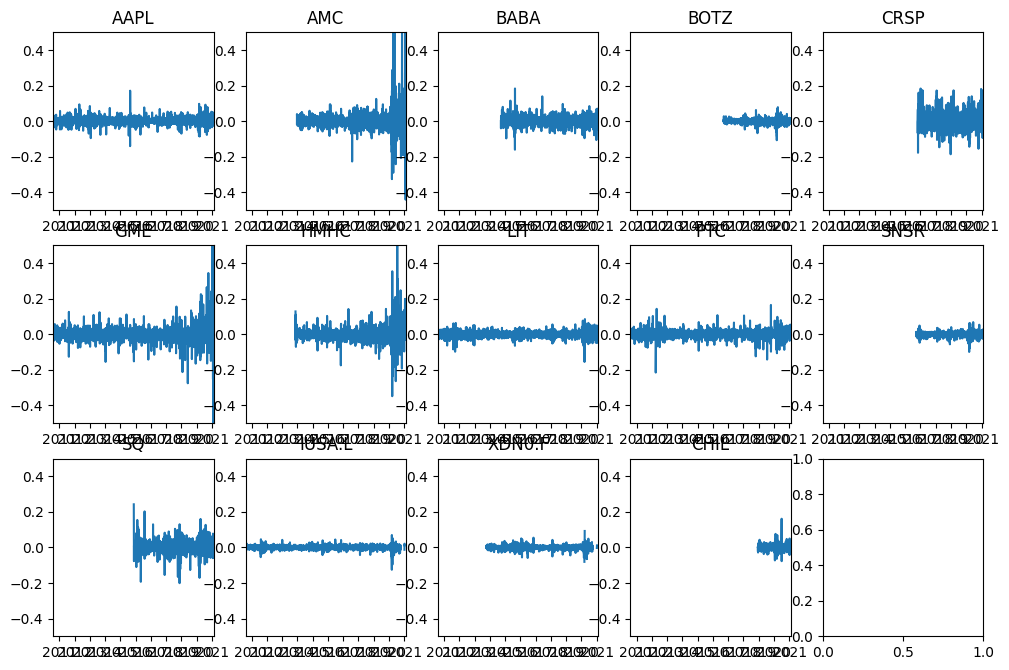

In [18]:
import matplotlib.pyplot as plt
import math
from itertools import product
plot_open_prices = lambda x: plt.plot(x.Date,x.Open)
returns_open = lambda x : (list(x.shift(-1).Date)[0:-1], list((x.shift(-1).Open /x.Open) -1)[0:-1])

def plot_daily_returns_open (x):
  data = returns_open(x)
  matplotlib.pyplot.plot (data[0],data[1])

n = len(portfolio_weights)
nx=int(math.sqrt(n))
ny=int(n/nx) if n/nx==int(n/nx) else int(n/nx)+1

fig, axs = plt.subplots(nx, ny,figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
i = 0
# Extracting dfs back into an array
plotdfs = [ portfolio_tickers_df[portfolio_tickers_df.Ticker==ticker_entry] for ticker_entry,_ in portfolio_weights]
xlim_min  = min(min(xdf.Date) for xdf in plotdfs)
xlim_max  = max(max(xdf.Date) for xdf in plotdfs)
for x,y in product(range(0,nx),range(0,ny)):
  if i < n:
    plot_data = returns_open(plotdfs[i])
    axs[x,y].set_xlim(xlim_min,xlim_max)
    axs[x,y].set_ylim(-.5,.5)
    axs[x,y].plot(plot_data[0],plot_data[1])
    axs[x,y].set_title(list(set(plotdfs[i].Ticker))[0])
  i=i+1


# Calculating Portfolio value for each day